In [1]:
import itertools
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = [16.5, 5]

In [2]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'Roboto Condensed'
matplotlib.rcParams.update({'font.size': 16})

In [3]:
import os
import json
import random
import csv
import copy
import scipy.stats as stats
from collections import namedtuple

## Setup

In [23]:
target_conditions = ['DM1', 'FRDA', 'FXS', 'HD']
scratch_dir = '../../scratch/'
input_dir = '../../input/'
output_dir = '../../output/'
results_path_template = os.path.join(scratch_dir, '{}/anchored.case-control.tsv')
variant_catalog_path = os.path.join(input_dir, 'variant_catalog.grch37.json')

## Load known repeat regions

In [9]:
Region = namedtuple('Region', 'contig start end'.split())

target_regions = {}


with open(variant_catalog_path, 'r') as catalog_file:
    catalog = json.load(catalog_file)


def decode_region(encoding):
    encoding = encoding.replace(':', '-').split('-')
    return Region(contig=encoding[0], start=int(encoding[1]), end=int(encoding[2]))


def get_region(encoding):
    if type(encoding) is not list:
        return decode_region(encoding)
    
    first_region = decode_region(encoding[0])
    last_region = decode_region(encoding[-1])
    
    return Region(first_region.contig, first_region.start, last_region.end)


for rec in catalog:
    locus_id = rec['LocusId']
    
    if locus_id not in ['DMPK', 'FMR1', 'FXN', 'HTT']:
        continue
    
    reference_regions = rec['ReferenceRegion']
    target_regions[locus_id] = get_region(reference_regions)

target_regions

{'DMPK': Region(contig='19', start=46273462, end=46273522),
 'FMR1': Region(contig='X', start=146993568, end=146993628),
 'FXN': Region(contig='9', start=71652177, end=71652220),
 'HTT': Region(contig='4', start=3076603, end=3076693)}

## Load results of secondary analysis

In [14]:
def overlaps(region_a, region_b):    
    if region_a.contig != region_b.contig:
        return False
    
    overlap = max(0, min(region_a.end, region_b.end) - max(region_a.start, region_b.start))
    return overlap != 0


def extract_results(condition):
    results = []
    path = results_path_template.format(condition)
    with open(path, 'r') as results_file:
        for line in results_file:
            contig, start, end, unit, raw_pval, adj_pval, *_ = line.split()
            
            if 'GL000' in contig or 'MT' in contig or contig == 'chrom':
                continue
            
            region = Region(contig, int(start), int(end))
            raw_pval = float(raw_pval)
            
            results.append({'condition': condition,
                            'region': region,
                            'unit': unit,
                            'raw_pval': raw_pval
                           })
    return results


def label_regions(sample_results):
    for region_results in sample_results:
        current_region = region_results['region']
        label = 'Unknown'
        for target_id, target_region in target_regions.items():
            if overlaps(current_region, target_region):
                assert label == 'Unknown'
                label = target_id
        region_results['label'] = label

In [15]:
#sample_paths = {'DMPK': '../../scratch/dm1/counts_airs.bed',
#                'FMR1': '../../scratch/fxs/counts_airs.bed',
#                'FXN': '../../scratch/frda/counts_airs.bed',
#                'HTT': '../../scratch/hd/counts_airs.bed'}

In [17]:
dataset_results = []

for condition in target_conditions:
    print('Extracting results for {}'.format(condition))
    condition_results = extract_results(condition)
    label_regions(condition_results)
    dataset_results.extend(condition_results)

print('Collected {} regions'.format(len(dataset_results)))

Extracting results for DM1
Extracting results for FRDA
Extracting results for FXS
Extracting results for HD
Collected 9117 regions


## Convert genomic coordinates to plot coordinates

In [18]:
chrom_sizes = {
  "MT": 16569,
  "1": 249250621,
  "2": 243199373,
  "3": 198022430,
  "4": 191154276,
  "5": 180915260,
  "6": 171115067,
  "7": 159138663,
  "8": 146364022,
  "9": 141213431,
  "10": 135534747,
  "11": 135006516,
  "12": 133851895,
  "13": 115169878,
  "14": 107349540,
  "15": 102531392,
  "16": 90354753,
  "17": 81195210,
  "18": 78077248,
  "19": 59128983,
  "20": 63025520,
  "21": 48129895,
  "22": 51304566,
  "X": 155270560,
  "Y": 59373566}

chrom_offset = {'{}'.format(i + 1) : i for i in range(22)}
chrom_offset['X'] = 22
chrom_offset['Y'] = 23
chrom_offset['MT'] = 24

def convert_genomic_to_plot_coordindates(region):
    chrom_len = chrom_sizes[region.contig]
    region_center = (region.start + region.end) / 2
    plot_coordindate = chrom_offset[region.contig] + region_center / chrom_len
    return plot_coordindate

def add_xaxis_positions(dataset_results):
    for region_results in dataset_results:
        region = region_results['region']
        region_results['xaxis'] = convert_genomic_to_plot_coordindates(region)

In [19]:
add_xaxis_positions(dataset_results)

In [20]:
dataset_results_df = DataFrame(dataset_results)
dataset_results_df['neglog_pval'] = -np.log10(dataset_results_df['raw_pval'])
dataset_results_df['neglog_pval'] = np.where(np.isinf(dataset_results_df['neglog_pval']),
                                             15,
                                             dataset_results_df['neglog_pval'])
dataset_results_df['color'] = np.where(np.trunc(dataset_results_df['xaxis']) % 2 == 0, '#56B4E9', '#D55E00') 
dataset_results_df.head()

/Users/edolzhenko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


,condition,label,raw_pval,region,unit,xaxis,neglog_pval,color
0,DM1,Unknown,0.043679,"(1, 8390795, 8391890)",AAAAAATATTTTT,0.033666,1.359723,#56B4E9
1,DM1,Unknown,0.283798,"(17, 79029790, 79031561)",AAAAACGCAACAGCAG,16.973342,0.546991,#56B4E9
2,DM1,Unknown,0.517941,"(19, 19013159, 19013810)",AAAAAGGAAAGG,18.321559,0.285720,#56B4E9
3,DM1,Unknown,0.553678,"(5, 78475692, 78476844)",AAAAAGGAAAGG,4.433774,0.256742,#56B4E9
4,DM1,Unknown,0.218283,"(19, 19854288, 19855415)",AAAAAGGAAAGGAAAGG,18.335789,0.660981,#56B4E9


## Visualize the results

In [21]:
def manhattan_plot(axis, sample_results):
    num_regions = sample_results.shape[0]
    significance_cutoff = -np.log10(0.01 / num_regions)
    axis.scatter(x='xaxis', y='neglog_pval', c='color', data=sample_results, rasterized=True)
    
    for row in sample_results[sample_results['label'] != 'Unknown'].iterrows():
        _, row = row
        
        if row['neglog_pval'] < significance_cutoff:
            continue
        
        x, y = (row['xaxis'], row['neglog_pval'])
        point_pos = (x, y)
        text_pos = x - 1.5, y - 1.5

        print(row['label'], point_pos)
        
        axis.annotate(row['label'],
                      xy=point_pos,
                      xycoords='data',
                      xytext=text_pos,
                      textcoords='data',
                      arrowprops={'arrowstyle': 'wedge', 'connectionstyle': 'arc3'},
                      bbox={'boxstyle': 'round,pad=0.3', 'fc': '#ecf0f1', 'ec': '#bdc3c7', 'lw': 2},
                      fontsize=14)

    axis.axhline(y=significance_cutoff, c='k', ls='--')
    axis.xaxis.set_ticks(np.arange(0.5, 24.5, 1.0))
    axis.xaxis.set_ticklabels(['{}'.format(i + 1) for i in range(22)] + ['X', 'Y'])
    axis.set(xlabel='Position', ylabel='-log(p-value)');

DMPK (18.78258417703548, 11.125285997359978)
FXN (8.507403375108137, 15.176438519807359)
FMR1 (22.94669279868637, 15.0)
HTT (3.0160948531436462, 7.228772131188429)


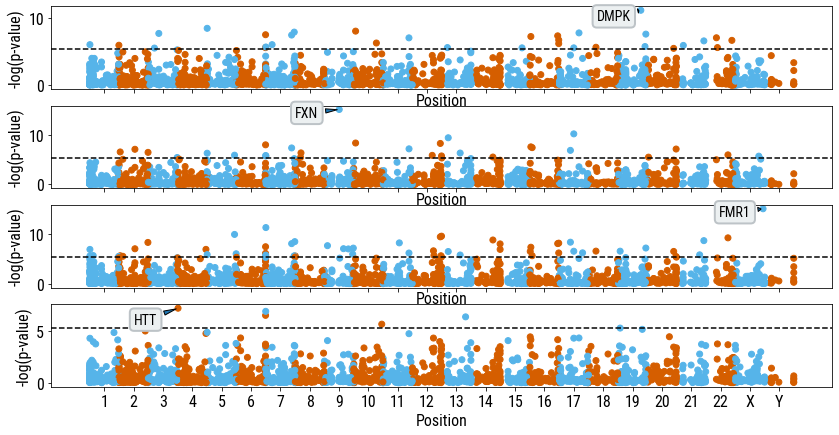

In [26]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 7), sharex=True)

for sample_index, (sample_id, sample_results) in enumerate(dataset_results_df.groupby(by='condition')):
    ax = axes[sample_index]
    manhattan_plot(ax, sample_results)
    #fig.savefig('../../output/case-control-{}.pdf'.format(sample_id), dpi=300, bbox_inches='tight');

fig.savefig(os.path.join(output_dir, 'case-control.pdf').format(sample_id), dpi=300, bbox_inches='tight');